In [ ]:
import pandas as pd

## Dask

Dask - пакет для параллельных вычислений на Python, совместимый с NumPy, Pandas, и scikit-learn. В Dask есть структура массивов, которая эквивалентна массивам в NumPy, датафреймы в Dask аналогичны датафреймам в Pandas, а Dask-ML – это аналог scikit-learn.

[Документация](https://docs.dask.org/en/stable/)

In [ ]:
!pip install s3fs > None # для загрузки данных из s3

In [ ]:
import dask.dataframe as dd

NYC taxi cab data 2015

Apache Parquet — это бинарный, колоночно-ориентированный формат хранения больших данных

### Dask Arrays

In [ ]:
import numpy as np
shape = (1000, 4000)
ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [ ]:
print('%.1f MB' % (ones_np.nbytes / (1024 * 1024)))

30.5 MB


In [ ]:
import dask.array as da

ones = da.ones(shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 4000), chunktype=numpy.ndarray>

In [ ]:
chunk_shape = (1000, 1000)
ones = da.ones(shape, chunks=chunk_shape)
ones

dask.array<ones_like, shape=(1000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [ ]:
ones.compute()

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

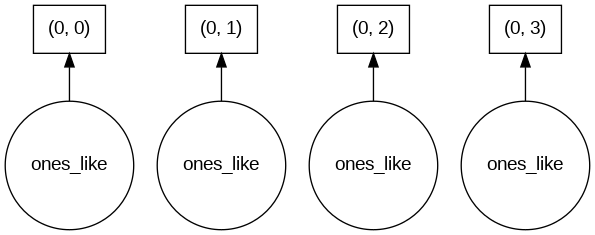

In [ ]:
ones.visualize()

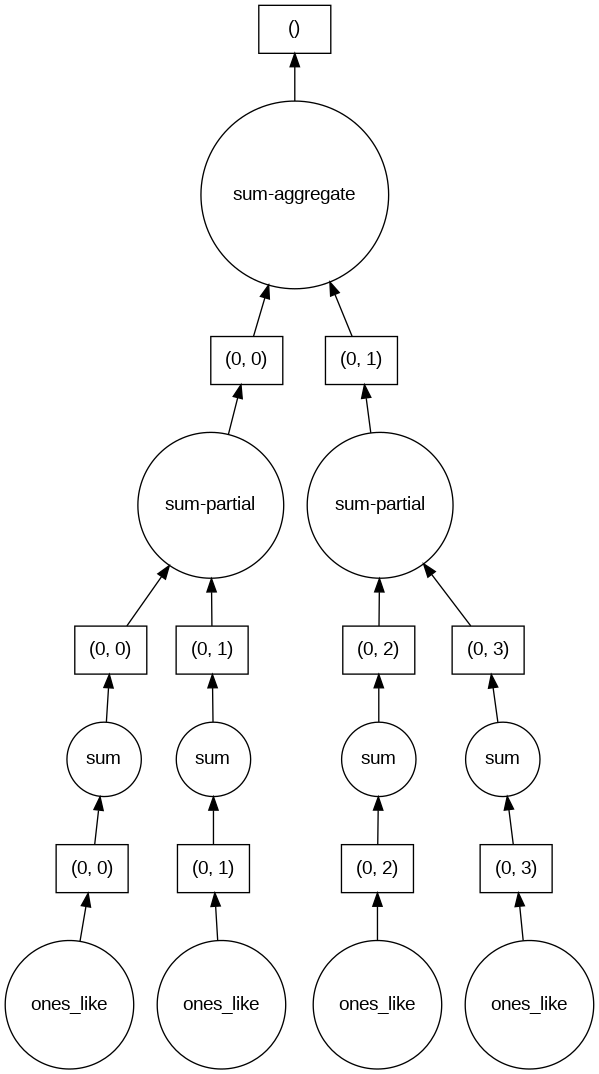

In [ ]:
sum_of_ones = ones.sum()
sum_of_ones.visualize()

Возьмем побольше данных

In [ ]:
bigshape = (200000, 4000)
big_ones = da.ones(bigshape, chunks=chunk_shape)
big_ones

dask.array<ones_like, shape=(200000, 4000), dtype=float64, chunksize=(1000, 1000), chunktype=numpy.ndarray>

In [ ]:
print('%.1f MB' % (big_ones.nbytes / (1024 * 1024)))

6103.5 MB


In [ ]:
big_calc = (big_ones * big_ones[::-1, ::-1]).mean()

result = big_calc.compute()
result

1.0

In [ ]:
big_ones_reduce = (np.cos(big_ones)**2).mean(axis=1)
big_ones_reduce

dask.array<mean_agg-aggregate, shape=(200000,), dtype=float64, chunksize=(1000,), chunktype=numpy.ndarray>

In [ ]:
import gc

del big_ones
del big_ones_reduce

gc.collect()

50

### Dask DataFrame

In [ ]:
ddf = dd.read_parquet(
    "s3://dask-data/nyc-taxi/nyc-2015.parquet/part.*.parquet",
    columns=["passenger_count", "tip_amount"],
    storage_options={"anon": True},
)

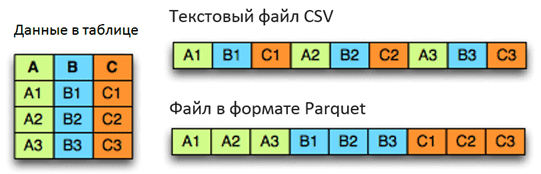

In [ ]:
ddf.head()

,passenger_count,tip_amount
0,5,0.0
1,3,0.0
2,1,0.0
3,1,0.0
4,2,0.0


In [ ]:
len(ddf)

146112989

In [ ]:
type(ddf)

dask.dataframe.core.DataFrame

Dask DataFrame состоит из множества объектов Pandas DataFrame/Series. Эти объекты pandas могут находиться на одном диске или на разных машинах.

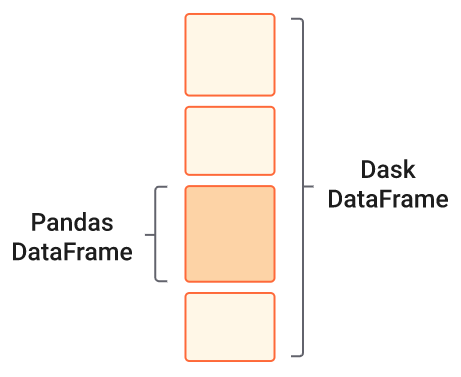

### Ленивые вычисления & граф вычислений

In [ ]:
result = ddf.groupby("passenger_count").tip_amount.mean()
result

Dask Series Structure:
npartitions=1
    float64
        ...
Name: tip_amount, dtype: float64
Dask Name: truediv, 7 graph layers

In [ ]:
result.visualize()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.971738 to fit


In [ ]:
result.visualize(filename='dask_graph.pdf')

In [ ]:
%%time

result.compute()

CPU times: user 16.1 s, sys: 3.93 s, total: 20 s
Wall time: 26.7 s


passenger_count
0    1.590343
1    1.752130
2    1.705595
3    1.579748
4    1.459269
5    1.728534
6    1.680769
7    3.863473
8    5.060718
9    5.075917
Name: tip_amount, dtype: float64

### Merging Pandas DataFrames

In [ ]:
pd_df_1 = pd.DataFrame(
    {
        "Name": ["Azza", "Brandon", "Cedric", "Devonte", "Eli", "Fabio"],
        "Age": [29, 30, 21, 57, 32, 19]
    }
)
ddf_1 = dd.from_pandas(pd_df_1, npartitions=2)

pd_df_2 = pd.DataFrame(
    {
        "Name": ["Azza", "Cedric", "Fabio"],
        "City": ["Beirut", "Dublin", "Rosario"]
    }
)

joined = ddf_1.merge(pd_df_2, how="left", on=["Name"])
joined

,Name,Age,City
npartitions=2,,,
,object,int64,object
,...,...,...
,...,...,...


In [ ]:
joined.compute()

,Name,Age,City
0,Azza,29,Beirut
1,Brandon,30,NaN
2,Cedric,21,Dublin
0,Devonte,57,NaN
1,Eli,32,NaN
2,Fabio,19,Rosario


### Dask Delayed

In [ ]:
import time

def inc(x):
    time.sleep(0.1)
    return x + 1

def dec(x):
    time.sleep(0.1)
    return x - 1

def add(x, y):
    time.sleep(0.2)
    return x + y

In [ ]:
%%timeit

x = inc(1)
y = dec(2)
z = add(x, y)
z

401 ms ± 34.8 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import dask

inc = dask.delayed(inc)
dec = dask.delayed(dec)
add = dask.delayed(add)

In [ ]:
%%timeit

x = inc(1)
y = dec(2)
z = add(x, y)

108 µs ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
x = inc(1)
y = dec(2)
z = add(x, y)

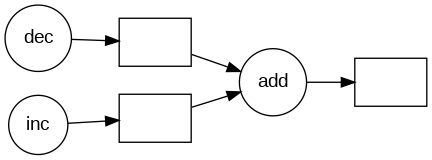

In [ ]:
z.visualize(rankdir='LR')

In [ ]:
%%timeit

z.compute()

302 ms ± 444 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
